<a href="https://colab.research.google.com/github/PeerChristensen/NatureImageClassifiers/blob/main/fastai_mushroom_classifier_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom image scraping and classification with fastai

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images (if we don't already have data)

In [ ]:
!pip install duckduckgo_search

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

We start by searching for a cantarel photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Boletus badius photos', max_images=1)
urls[0]

Searching for 'Boletus badius photos'


'https://identifier-les-champignons.com/wp-content/uploads/2020/06/Boletus_badius_stem-scaled.jpg'

...and then download a URL and take a look at it:

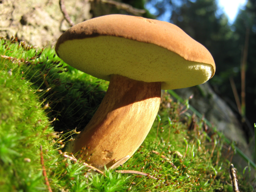

In [ ]:
from fastdownload import download_url
dest = 'boletus_badius.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "Dog photos":

In [ ]:
download_url(search_images('dog photo', max_images=1)[0], 'Dog.jpg', show_progress=False)
Image.open('Dog.jpg').to_thumb(256,256)


We can import a list of all the names of mushrooms to search for

In [ ]:
import pandas as pd
import random

df = pd.read_csv("danish_mushrooms.csv")
searches = df.lat_name.to_list()

path = Path('/mushrooms')

An then search and download images for each name. A fe cells above, we set the number of images to find to 50.

In [ ]:
from time import sleep

for n,o in enumerate(searches):
    print(f"{n+1} of {len(searches)}")
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(2)  # Pause between searches to avoid over-loading server
    #download_images(dest, urls=search_images(f'{o} sun photo'))
    #sleep(2)
    #download_images(dest, urls=search_images(f'{o} shade photo'))
    #sleep(2)
    resize_images(path/o, max_size=400, dest=path/o)
    
print("\nDONE!")

We can check for failed images and remove those that have failed.

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

We can then store our images in Google Drive for later.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r './mushrooms' /content/drive/MyDrive/mushrooms/

## Step 2: Train our model

In case we don't need to complete step 1, we can mount or data storage and set the path.

NOTE: if using timm models, make sure to import timm before fastai

In [3]:
!pip install -U timm
import timm

from google.colab import drive
from fastcore.all import *
from fastai.vision.all import *

drive.mount('/content/drive')

path = Path('/content/drive/MyDrive/mushrooms')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 27.0 MB/s 
Mounted at /content/drive


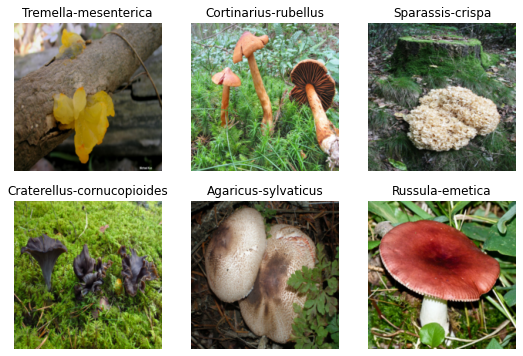

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')] # or crop or pad
)
dls = db.dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. Other options are ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-110, ResNet-152, ResNet-164, ResNet-1202
Remember to use GPU.

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(7)

# resnet 18, 5 eps, err rate = .398, w aug .358
# resnet 50, 7 eps, err rate = .351, w aug 0.279

## Using data augmentation


Example of updating dataloaders

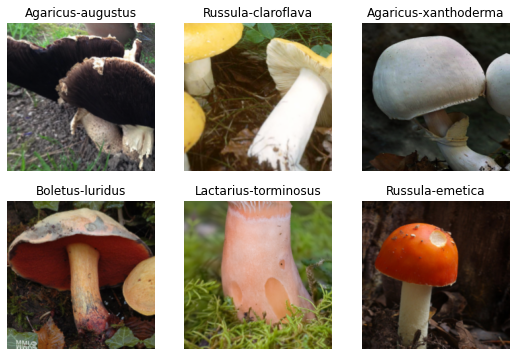

In [5]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')] # or crop or pad
)

dls = data.dataloaders(path, bs=32)

data = data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = data.dataloaders(path, bs=8)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(7)

What is the optimal learning rate?


steep: 0.0030199517495930195\minimum: 0.0033113110810518267


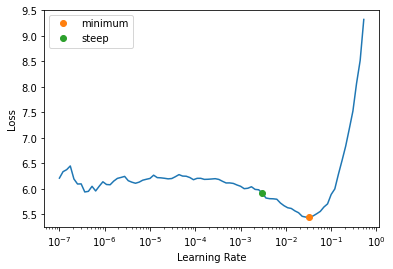

In [30]:
learn = vision_learner(dls, 'convnext_base_in22ft1k', metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"\nsteep: {lr_steep}\minimum: {lr_min}")

## Using ConvNext


What other models are available?

In [ ]:
!pip install -U timm
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

In [ ]:
#!pip install huggingface_hub

In [34]:
from fastai.vision.all import *

learn = vision_learner(dls, 'convnext_base_in22ft1k', metrics=error_rate)

#learn.fine_tune(7) # .17, 5 eps is best
learn.fine_tune(7, base_lr=.003) # .174, 5 eps is best (.168)

epoch,train_loss,valid_loss,error_rate,time
0,1.997971,1.468122,0.391979,03:16


epoch,train_loss,valid_loss,error_rate,time
0,1.164159,0.850566,0.266494,03:59
1,1.093234,0.858171,0.238034,03:57
2,0.796187,0.784880,0.230272,03:57
3,0.513423,0.715049,0.209573,03:57
4,0.312439,0.650119,0.168176,03:59
5,0.237671,0.666849,0.177232,03:57
6,0.171221,0.633816,0.174644,03:59


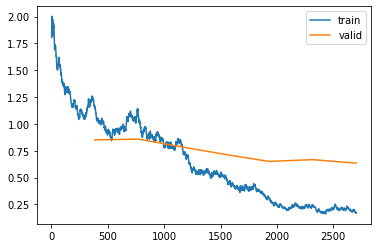

In [35]:
learn.recorder.plot_loss()

In [12]:
learn.export('mushroom_model_convnext_base_7eps.pkl')

#from google.colab import files
#files.download("mushroom_model_rn18_5eps.pkl")
!cp -r './mushroom_model_convnext_base_7eps.pkl' /content/drive/MyDrive/mushrooms/



In [ ]:
'''import os
#os.chdir(r'/kaggle/working')

!tar -czf flowers100_50each.tar.gz flowers

from IPython.display import FileLink

FileLink(r'flowers100_50each.tar.gz')
files.download("flowers100_50each.tar.gz")

'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [15]:
learn.dls.vocab
#len(learn.dls.vocab)

['Agaricus-arvensis', 'Agaricus-augustus', 'Agaricus-bisporus', 'Agaricus-campestris', 'Agaricus-sylvaticus', 'Agaricus-sylvicola', 'Agaricus-xanthoderma', 'Amanita-excelsa', 'Amanita-fulva', 'Amanita-muscaria', 'Amanita-pantherina', 'Amanita-phalloides', 'Amanita-rubescens', 'Amanita-virosa', 'Auricularia-auricula-judae', 'Auriscalpium-vulgare', 'Bankera-fuligineoalba', 'Boletus-badius', 'Boletus-chrysenteron', 'Boletus-edulis', 'Boletus-luridiformis', 'Boletus-luridus', 'Boletus-reticulatus', 'Boletus-satanas', 'Boletus-subtomentosus', 'Calocybe-gambosa', 'Cantharellus-cibarius', 'Cantharellus-tubaeformis', 'Chlorophyllum-olivieri', 'Clitocybe-nebularis', 'Coprinopsis-atramentaria', 'Coprinus-comatus', 'Cortinarius-rubellus', 'Craterellus-cornucopioides', 'Creolophus-cirrhatus', 'Entoloma-eulividum', 'Flammulina-velutipes', 'Fomes-fomentarius', 'Fomitopsis-pinicola', 'Galerina-marginata', 'Gyromitra-esculenta', 'Hericium-coralloides', 'Hydnellum-peckii', 'Hydnum-repandum', 'Hygrophor

In [36]:
#print(len(dls.vocab))

label_ind = [x for x,element in enumerate(learn.dls.vocab) if element == "Boletus-badius"][0]
print(label_ind)

17


In [37]:
pred,_,probs = learn.predict(PILImage.create('drive/MyDrive/mushrooms/boletus-badius-test.jpg'))
print(f"This is an: {pred}.")
print(f"Probability: {probs[label_ind]:.4f}")
print()

This is an: Boletus-badius.
Probability: 0.2468



## Performance

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

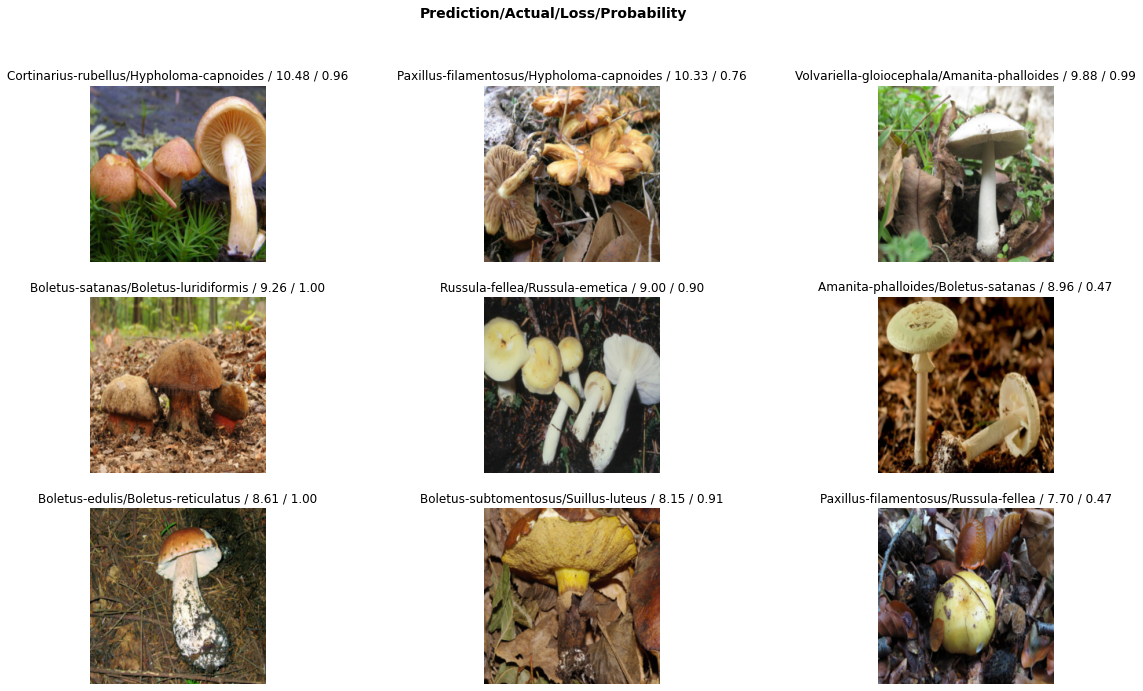

In [26]:
interp.plot_top_losses(9, figsize=(20,11))

In [27]:
interp.most_confused(min_val=2)

[('Russula-emetica', 'Russula-paludosa', 5),
 ('Russula-paludosa', 'Russula-emetica', 5),
 ('Agaricus-arvensis', 'Agaricus-xanthoderma', 4),
 ('Boletus-badius', 'Boletus-reticulatus', 4),
 ('Russula-claroflava', 'Russula-ochroleuca', 4),
 ('Chlorophyllum-olivieri', 'Macrolepiota-procera', 3),
 ('Hypholoma-capnoides', 'Hypholoma-fasciculare', 3),
 ('Lyophyllum-decastes', 'Entoloma-eulividum', 3),
 ('Paxillus-involutus', 'Paxillus-filamentosus', 3),
 ('Agaricus-bisporus', 'Agaricus-sylvaticus', 2),
 ('Agaricus-sylvaticus', 'Agaricus-sylvicola', 2),
 ('Agaricus-sylvicola', 'Amanita-virosa', 2),
 ('Amanita-excelsa', 'Amanita-pantherina', 2),
 ('Amanita-pantherina', 'Amanita-excelsa', 2),
 ('Amanita-phalloides', 'Volvariella-gloiocephala', 2),
 ('Boletus-edulis', 'Boletus-reticulatus', 2),
 ('Boletus-luridiformis', 'Boletus-luridus', 2),
 ('Coprinus-comatus', 'Coprinopsis-atramentaria', 2),
 ('Entoloma-eulividum', 'Clitocybe-nebularis', 2),
 ('Inocybe-erubescens', 'Russula-fellea', 2),
 ('K

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

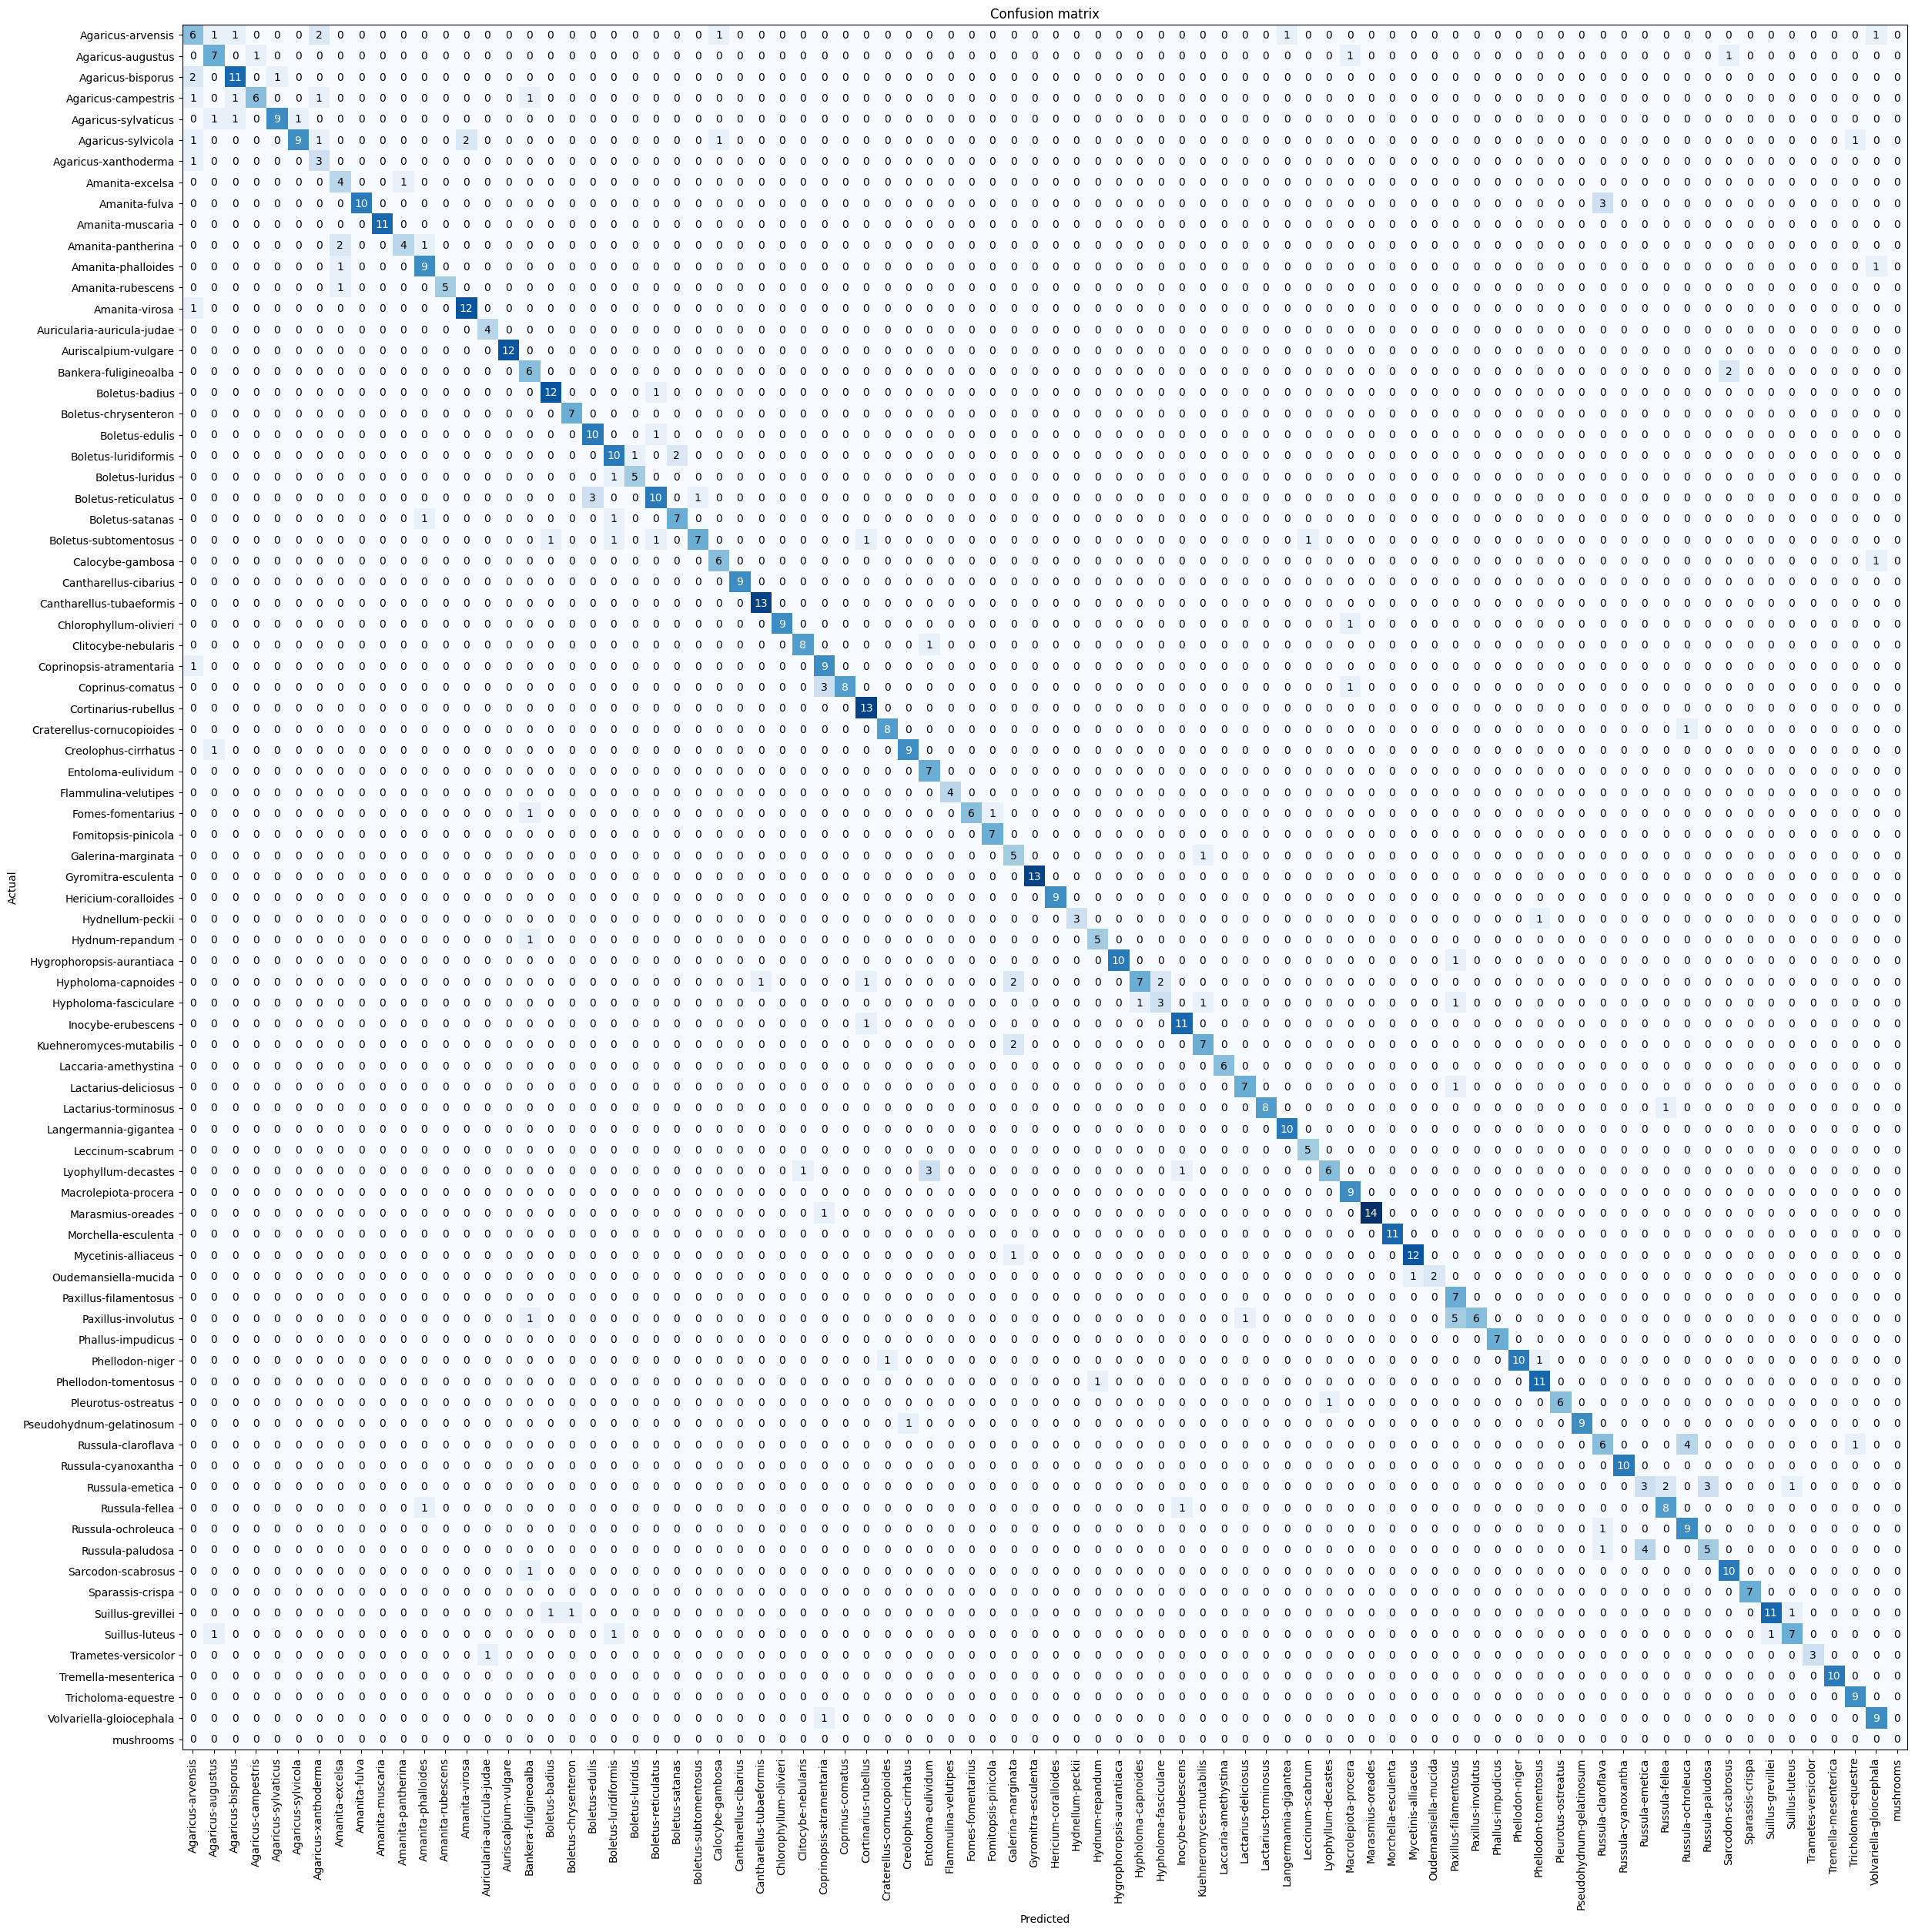

In [39]:
interp.plot_confusion_matrix(figsize=(25,25), dpi=100)